In [2]:
# Initial setup
import pandas as pd
import numpy as np
import json
import warnings
warnings.filterwarnings('ignore')

df_full = pd.read_json('yelp_academic_dataset_business.json', lines = True)
tip = pd.read_json('yelp_academic_dataset_tip.json', lines = True)

## 1. Data Preprocessing
In this section, we will transform the Yelp dataset and produce the format required for data mining and modeling through the following steps:

- Filter to U.S. restaurants that were opened in 2016
- Flatten attributes and categories
- Transform categorical variables into dummy variables
- Handling missing values

In [174]:
# Filter to U.S. restaurants that were opened in 2016
# 1) Filter to U.S. businesses
zip_crosswalk = pd.read_csv('zip_crosswalk.csv')
# Transform digit-only postal code to int
digit_only = df_full['postal_code'].map(lambda x: True if all(i.isdigit() for i in x) else False)
df_full = df_full[(digit_only) & (df_full['postal_code'] != '')]
df_full['postal_code_int'] = [int(x) for x in df_full['postal_code']]
# Join crosswalk by zip and state
df_us = pd.merge(df_full, zip_crosswalk[['ZIP', 'STATE']], 
              left_on = ['postal_code_int', 'state'],
              right_on = ['ZIP', 'STATE'])

# 2) Filter to restaurants
df_us = df_us[df_us['categories'].str.contains('Restaurants|Food', na = False)]

# 3) Filter to restaurants that were opened in 2016
start = '2015-01-01'
end = '2016-12-31'
tip = tip.groupby('business_id')['date'].min().reset_index()
tip = tip[(tip['date'] >= start) & (tip['date'] <= end)]
df = pd.merge(tip, df_us, on = 'business_id')

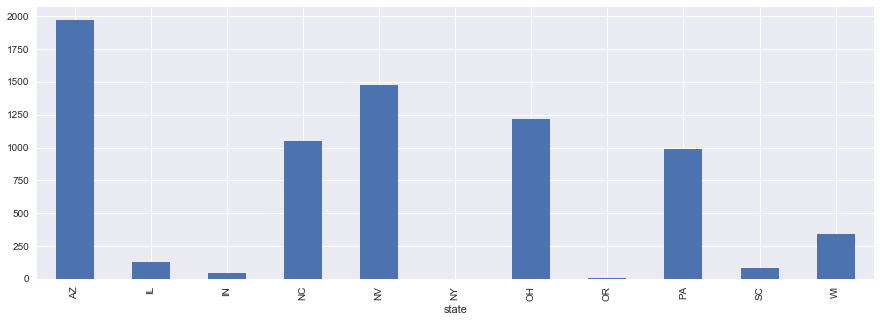

In [175]:
# Check geological distribution
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
df.groupby('state')['business_id'].count().plot(kind = 'bar')
plt.show()

In [176]:
# Drop states with few data points
state_list = ['AZ', 'NC', 'NV', 'OH', 'PA', 'WI']
print('Total data points in df:', len(df))
df = df[np.in1d(df['state'], state_list)].reset_index()
print('Total data points in df after removing a few states:', len(df))

Total data points in df: 7303
Total data points in df after removing a few states: 7043


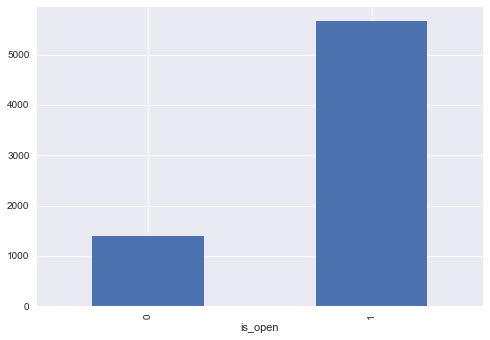

In [177]:
# Check restaurant closure
df.groupby('is_open')['business_id'].count().plot(kind = 'bar')
plt.show()

In [178]:
# Flatten attributes and categories
# 1) Categories
from collections import Counter
# Extract categories from list of lists
cat = ', '.join(df['categories'])
# Count frequency
counter = Counter(cat.split(', '))
# Append categories as dummies
for cat in list(counter.keys()):
    df[cat] = np.where(df['categories'].str.contains(cat), 1, 0)
df.drop('categories', inplace = True, axis = 1)

In [179]:
# 2) Attributes
# Unuseful attributes to be dropped
drop_list = ['AcceptsInsurance', 'AgesAllowed', 'Ambience', 'BYOB', 'BYOBCorkage', 'DietaryRestrictions',
             'BestNights', 'BikeParking', 'BusinessAcceptsBitcoin', 'Music', 'ByAppointmentOnly',
             'CoatCheck', 'DogsAllowed' , 'DriveThru', 'GoodForDancing', 'Smoking', 'BusinessParking', 'GoodForMeal']
# Flattening
att = df['attributes'].apply(pd.Series)
meal = att['GoodForMeal'].fillna("{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'breakfast': False, 'brunch': False}")
parking = att['BusinessParking'].fillna("{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}")
parking_list = ['garage', 'street', 'validated', 'lot', 'valet']
meal_list = ['dessert', 'latenight', 'lunch', 'dinner', 'breakfast', 'brunch']

# Define a function to flatten json lists
import ast
def flatten_json(df, col):
    for i in range(len(col)):
        json_dict = ast.literal_eval(col[i])
        for j in json_dict.keys():
            df[j] = np.where(json_dict[j], 1, 0) 
            
flatten_json(df = att, col = parking)
flatten_json(df = att, col = meal)

# Handle missing value in attributes
att['Alcohol'].fillna('none', inplace = True)
att['NoiseLevel'].fillna('average', inplace = True)
att['RestaurantsAttire'].fillna('casual', inplace = True)
att['WiFi'].fillna('no', inplace = True)
att['RestaurantsPriceRange2'].fillna(0, inplace = True)

# Transform attributes into dummy variables
att = att.drop(drop_list, axis = 1).fillna(value = False)
att = pd.get_dummies(att, drop_first = True)

# Append attributes to main dataframe
df = pd.merge(df, att, left_index = True, right_index = True)
df.drop('attributes', axis = 1, inplace = True)

In [37]:
# Transform categorical variables into dummy

In [38]:
# Handling missing values

## 2. External Data
In this section, we will integrate the following external data sources to the Yelp dataset:
- Zillow property price data
- Demographic data by zip code

In [180]:
# Zillow
zillow = pd.read_csv('zillow_median_price.csv', encoding='cp1252')
# Extract zipcodes
zipcodes = df['postal_code'].unique()
df['postal_code_int'] = [int(i) for i in df['postal_code']]
house_price = zillow[np.in1d(zillow['RegionName'], 
                             df['postal_code_int'])][['RegionName', '2016-01']]
house_price.columns = ['postal_code_int', 'median_sqft_price']
# Append median house price to main df
df = pd.merge(df, house_price, on = 'postal_code_int')
df['median_sqft_price'] = df['median_sqft_price'].fillna(df['median_sqft_price'].median())

In [40]:
# Add zip-level demographics
from uszipcode import SearchEngine
keys = ['zipcode', 'housing_units', 'land_area_in_sqmi', 'median_home_value', 'median_household_income', \
        'occupied_housing_units', 'population', 'population_density', 'annual_individual_earnings', \
        'educational_attainment_for_population_25_and_over', 'employment_status', 'families_vs_singles', \
        'households_with_kids', 'housing_occupancy', 'means_of_transportation_to_work_for_workers_16_and_over', \
        'population_by_age', 'population_by_gender', 'population_by_race', 'travel_time_to_work_in_minutes']
lst = []
for zipcode in zipcodes:
    search = SearchEngine(simple_zipcode=False) 
    item = search.by_zipcode(zipcode)
    newDict  = item.to_dict()
    lst.append([newDict.get(key) for key in keys])
keys[0] = 'postal_code'
df_demograph = pd.DataFrame(lst, columns=keys)
df = pd.merge(df, df_demograph, on='postal_code', how='inner')

## 3. Feature Engineering
In this section, we will perform feature engineering to extract the following attributes:
- Restaurant density and competition level in the neighborhood
- Whether a given restaurant belong to a local/national chain

In [ ]:
# Restaurant density

In [42]:
# Chain